**Imports**

In [ ]:
pip install patool

     |████████████████████████████████| 81kB 3.6MB/s 


In [ ]:
import os
import shutil
import patoolib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPool2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3

**Extraction**

In [ ]:
# Extracting dataset from .rar to desired folder

os.mkdir(r'/content/extracted_content')

patoolib.extract_archive(r'/content/drive/My Drive/Data Science Projects/Face Mask Safeness Detection/New Masks Dataset.rar', 
                         outdir = r'/content/extracted_content' , verbosity=0)

patool: Extracting /content/drive/My Drive/Data Science Projects/Face Mask Safeness Detection/New Masks Dataset.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/Data Science Projects/Face Mask Safeness Detection/New Masks Dataset.rar"
patool:     with cwd='/content/extracted_content'
patool: ... /content/drive/My Drive/Data Science Projects/Face Mask Safeness Detection/New Masks Dataset.rar extracted to `/content/extracted_content'.


'/content/extracted_content'

**Creating Necessary Files**

In [ ]:
mask_files = []
non_mask_files = []
path = r'/content/extracted_content/New Masks Dataset/Test/Mask/'
for _, _, f in os.walk(path):
    mask_files = f.copy()

path = r'/content/extracted_content/New Masks Dataset/Test/Non Mask/'
for _, _, f in os.walk(path):
    non_mask_files = f.copy()

print("{} Mask Images Found in class 0.".format(len(mask_files)))
print("{} Non Mask Images Found in class 1.".format(len(non_mask_files)))

50 Mask Images Found in class 0.
50 Non Mask Images Found in class 1.


In [ ]:
mask = pd.DataFrame({"Image":mask_files , 'Class':list(np.zeros(len(mask_files) , dtype='int8'))})
non_mask = pd.DataFrame({"Image":non_mask_files , 'Class':list(np.ones(len(non_mask_files) , dtype='int8'))})

In [ ]:
test = pd.concat([mask,non_mask] , ignore_index=True)
test = test.sample(frac=1).reset_index(drop=True)

for i in range(len(test)):
    if (test.loc[i,'Class'] == 0):
        test.loc[i,'Class'] = "Mask"
    else:
        test.loc[i,'Class'] = "Non_Mask"

**Moving and Deleting files**

In [ ]:
# Making all images directory
os.mkdir(r'/content/extracted_content/New Masks Dataset/Test/Unknown')

In [ ]:
dest = r'/content/extracted_content/New Masks Dataset/Test/Unknown'

for i in range(len(mask)):
    source = r'/content/extracted_content/New Masks Dataset/Test/Mask/' + str(mask.loc[i , 'Image'])
    shutil.move(source , dest)

for i in range(len(non_mask)):
    source = r'/content/extracted_content/New Masks Dataset/Test/Non Mask/' + str(non_mask.loc[i , 'Image'])
    shutil.move(source , dest)

# Deleting unnecessary folders
shutil.rmtree(r'/content/extracted_content/New Masks Dataset/Test/Mask/')
shutil.rmtree(r'/content/extracted_content/New Masks Dataset/Test/Non Mask/')

**Image Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(rotation_range = 30 , shear_range=.15 , zoom_range=.15,
                                  width_shift_range=.2 , height_shift_range=.2 , rescale=1/255,
                                  brightness_range=[.5,1.5] , horizontal_flip=True , fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(r"/content/extracted_content/New Masks Dataset/Train",
                                      class_mode = 'binary', batch_size=20, target_size = (256,256) , shuffle=True)

val_datagen = ImageDataGenerator(rotation_range = 30 , shear_range=.15 , zoom_range=.15,
                                  width_shift_range=.2 , height_shift_range=.2 , rescale=1/255,
                                  brightness_range=[.5,1.5] , horizontal_flip=True , fill_mode='nearest')

val_generator = train_datagen.flow_from_directory(r"/content/extracted_content/New Masks Dataset/Validation",
                                      class_mode = 'binary', batch_size=20, target_size = (256,256) , shuffle=True)

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_dataframe(test , r"/content/extracted_content/New Masks Dataset/Test/Unknown" ,
                                              x_col='Image', y_col=None , target_size = (256,256) ,
                                              class_mode = None , batch_size = 1 , shuffle = False)

Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Found 100 validated image filenames.


**Callbacks**

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.99):
            print("\nReached 99.00% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

LR_reduce = ReduceLROnPlateau(monitor='val_accuracy' , factor=.5 , patience=5 , min_lr=.000001 , verbose=1)

ES_monitor = EarlyStopping(monitor='val_loss' , patience=5)

**Model Creation**

In [ ]:
# Resets global graph , counters etc.

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

pre_trained_model = VGG19(input_shape = (256, 256, 3), include_top = False, weights = "imagenet" )

for layer in pre_trained_model.layers:
      layer.trainable = False

pre_trained_model.summary()

80142336/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [ ]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator , validation_data = val_generator , batch_size=20 , validation_batch_size=20 ,
                    epochs=50 , verbose=1 , steps_per_epoch=30 , validation_steps=16 , callbacks=[callbacks,LR_reduce,ES_monitor])

Epoch 1/50
30/30 [==============================] - 33s 1s/step - loss: 5.3340 - accuracy: 0.5717 - val_loss: 0.4206 - val_accuracy: 0.7810 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - 31s 1s/step - loss: 0.7710 - accuracy: 0.6933 - val_loss: 0.4568 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 3/50
30/30 [==============================] - 31s 1s/step - loss: 0.5098 - accuracy: 0.7900 - val_loss: 0.3099 - val_accuracy: 0.8856 - lr: 0.0010
Epoch 4/50
30/30 [==============================] - 31s 1s/step - loss: 0.4921 - accuracy: 0.7967 - val_loss: 0.2846 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 5/50
30/30 [==============================] - 32s 1s/step - loss: 0.3765 - accuracy: 0.8550 - val_loss: 0.3660 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 6/50
30/30 [==============================] - 32s 1s/step - loss: 0.4091 - accuracy: 0.8483 - val_loss: 0.5753 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 7/50
30/30 [==============================] - 31s 1s/step - loss: 0.3652 - a

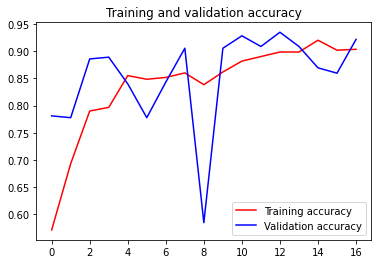

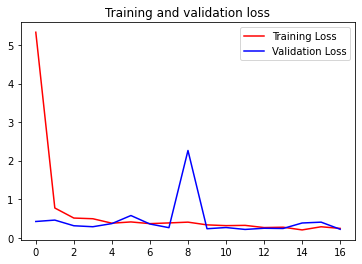

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Prediction**

In [ ]:
prediction = model.predict(test_generator)
for i in range(len(prediction)):
    if (prediction[i] >= 0.5):
        prediction[i] = 1
    else:
        prediction[i] = 0

In [ ]:
train_generator.class_indices

{'Mask': 0, 'Non Mask': 1}

In [ ]:
for i in range(len(test)):
    if (test.loc[i,'Class'] == 'Non_Mask'):
        test.loc[i,'Class'] = 1
    else:
        test.loc[i,'Class'] = 0

test['Class'] = test['Class'].astype('int')

In [ ]:
confusion_matrix(test.iloc[:,-1].values , prediction) 

array([[49,  1],
       [ 0, 50]])

In [ ]:
print(classification_report(test.iloc[:,-1].values , prediction))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



**Model Saving**

In [ ]:
model.save('VGG19_mask_predict.h5')

In [ ]:
shutil.move(r'/content/VGG19_mask_predict.h5' , r'/content/drive/My Drive/Colab Notebooks')

'/content/drive/My Drive/Colab Notebooks/VGG19_mask_predict.h5'